In [1]:
import numpy as np
import random
import os
import PIL
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython import display
import pandas as pd
%matplotlib inline
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.regularizers import l2
from tensorflow.python.framework import ops
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
plt.rcParams['figure.figsize'] = (20, 15)



# Exploring the image data

In [2]:
path = '../input/marvel-character-images/'
labels = ['good', 'evil']

In [3]:
def show_random_images(path, labels):
        for i in range(20):
            label_idx = random.randint(0, len(labels)-1) # Select folder at random to choose from
            im_path = path + labels[label_idx] + '/'
            image_idx = random.randint(0, len([name for name in os.listdir(im_path)])-1) # Select image at random from folder
            image_names = [name for name in os.listdir(im_path) ]
            plt.subplot(4,5,i+1).set_title(labels[label_idx])
            plt.imshow(PIL.Image.open(im_path + image_names[image_idx]))

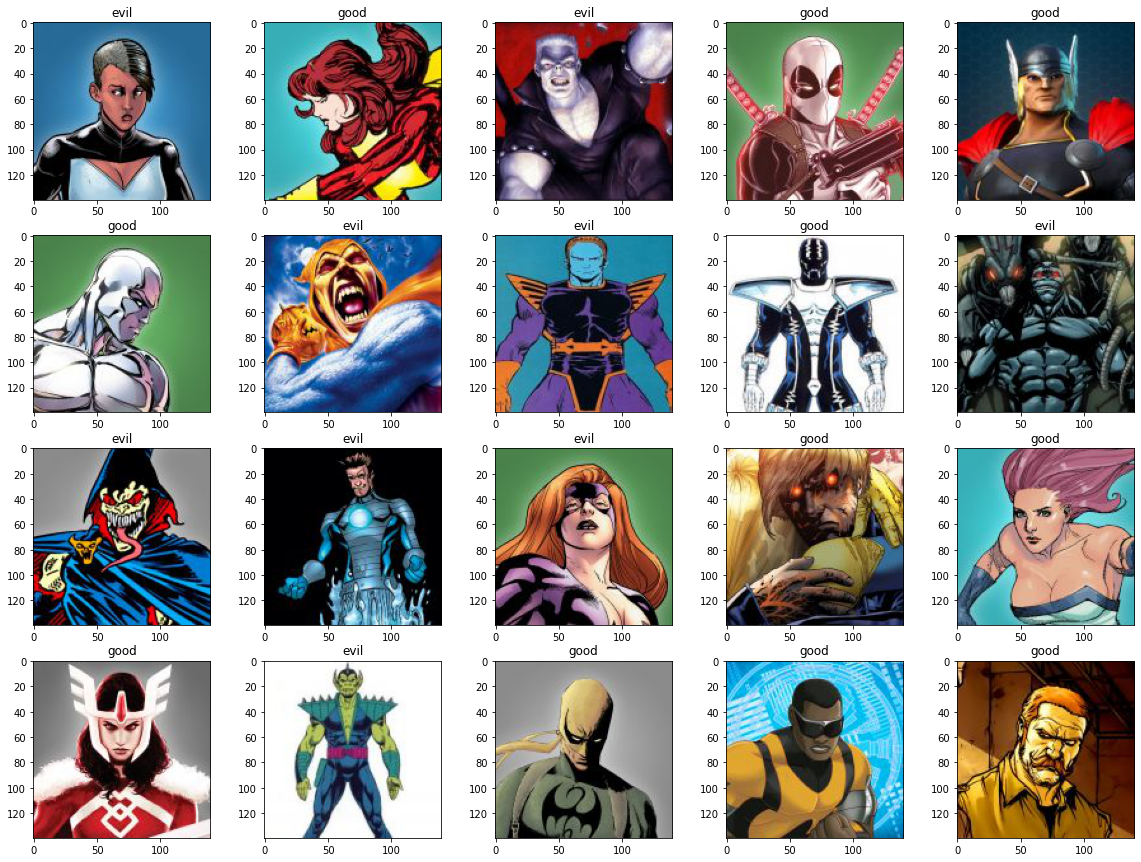

In [4]:
show_random_images(path, labels)

In [5]:
total_heroes = len([name for name in os.listdir(path + labels[0] + '/')])
total_villains = len([name for name in os.listdir(path + labels[1] + '/')])
total_images = total_heroes + total_villains

## Create an array of resized images
images = np.empty((total_images, 140, 140, 3),dtype=np.int32)
classes = np.empty(total_images,dtype=np.int32)
n = 0
for i in range(len(labels)):
    im_path = path + labels[i] + '/'
    for name in os.listdir(im_path):
        classes[n] = i
        images[n,:,:,:] = np.array(PIL.Image.open(im_path + name))
        n += 1

In [6]:
## Define function that will one-hot encode the target values
def one_hot_encode(target):
    n_values = np.max(target) + 1
    one_hot = np.eye(n_values)[target]
    return(one_hot)

X = images
y = classes.reshape(classes.shape[0], 1)

print('X shape:', X.shape)
print('y.shape:', y.shape)

X shape: (597, 140, 140, 3)
y.shape: (597, 1)


In [7]:
## Split X and y into training and test features + target.
seed=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=seed)


# Quick sanity check to make sure we have the desired array shapes
print("X training shape:", X_train.shape)
print("y training shape:", y_train.shape)
print("X testing shape:", X_test.shape)
print("y testing shape:", y_test.shape)

X training shape: (447, 140, 140, 3)
y training shape: (447, 1)
X testing shape: (150, 140, 140, 3)
y testing shape: (150, 1)


In [8]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential([])
    data_augmentation.add(RandomFlip('horizontal'))   
    data_augmentation.add(RandomRotation(0.2))
    return data_augmentation

In [9]:
class_weights = {0: 1.,
                1: 2.03,
                }

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input #preprocess input with pre-trained weights

def transfer_model(image_shape=(140,140), data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape) 
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)   
    x = tfl.GlobalAveragePooling2D()(x) 
    x = tfl.Dense(512, activation='relu',kernel_regularizer=l2(0.1))(x)
    outputs = tfl.Dense(1, activation='sigmoid',kernel_regularizer=l2(0.1))(x)
    model = tf.keras.Model(inputs, outputs)

    return model

model = transfer_model()

2022-02-23 19:03:46.976120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 19:03:47.088788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 19:03:47.089566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 19:03:47.091519: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
# Define initial epochs and base_learning rate and then compile
initial_epochs = 20
base_lr = 1e-3
model.compile(optimizer=tf.optimizers.Adam(learning_rate=base_lr),
              loss='binary_crossentropy',
              metrics=['BinaryAccuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 140, 140, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 140, 140, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 140, 140, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 140, 140, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(2)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(2)

history = model.fit(train_dataset, epochs=initial_epochs, validation_data=test_dataset,class_weight=class_weights,)

2022-02-23 19:03:51.672919: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-02-23 19:03:55.239106: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


224/224 [==============================] - 13s 17ms/step - loss: 16.1351 - binary_accuracy: 0.4765 - val_loss: 2.9083 - val_binary_accuracy: 0.7333
Epoch 2/20
224/224 [==============================] - 3s 15ms/step - loss: 1.9798 - binary_accuracy: 0.5414 - val_loss: 0.9690 - val_binary_accuracy: 0.6933
Epoch 3/20
224/224 [==============================] - 3s 14ms/step - loss: 1.1875 - binary_accuracy: 0.5660 - val_loss: 0.7760 - val_binary_accuracy: 0.7133
Epoch 4/20
224/224 [==============================] - 3s 13ms/step - loss: 1.0407 - binary_accuracy: 0.5817 - val_loss: 0.7504 - val_binary_accuracy: 0.6333
Epoch 5/20
224/224 [==============================] - 3s 13ms/step - loss: 0.9916 - binary_accuracy: 0.5906 - val_loss: 0.7343 - val_binary_accuracy: 0.6000
Epoch 6/20
224/224 [==============================] - 4s 17ms/step - loss: 0.9693 - binary_accuracy: 0.5503 - val_loss: 0.7110 - val_binary_accuracy: 0.5867
Epoch 7/20
224/224 [==============================] - 3s 14ms/step 

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

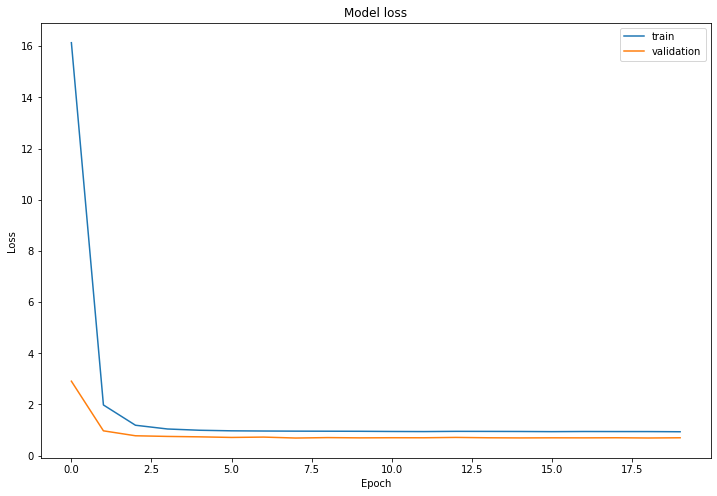

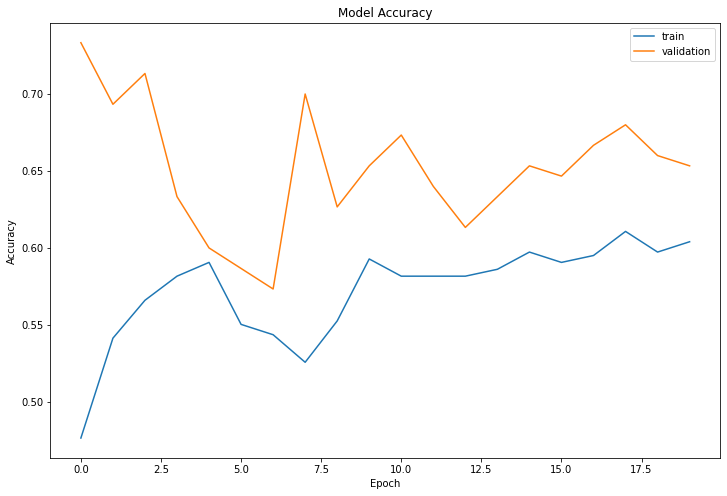

In [13]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['binary_accuracy','val_binary_accuracy']]
df_acc.rename(columns={'binary_accuracy':'train','val_binary_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [14]:
predictions = model.predict(X_test)

In [15]:
prediction = np.where(predictions <= 0.5, 0, 1)

In [16]:
incorrects = prediction != y_test

In [17]:
incorrect_idx = np.where(incorrects == True)[0]

In [18]:
r = random.choice(incorrect_idx)

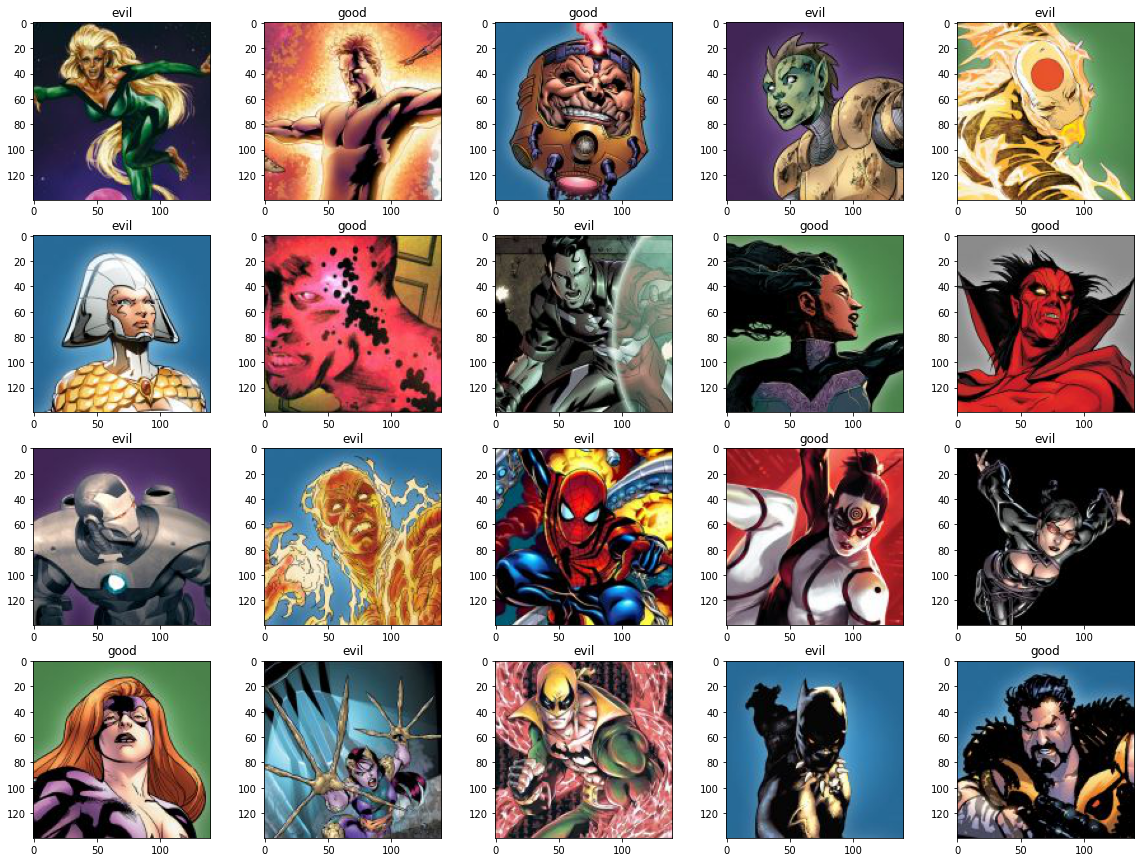

In [19]:
rand = []
i = 0
while i < 20:
        r = random.choice(incorrect_idx)
        if r not in rand:
            rand.append(r)
            plt.subplot(4,5,i+1).set_title('{}'.format(labels[prediction[r][0]]))
            plt.imshow(X_test[r,:,:,:])
            rand.append(r)
            i += 1